# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.cluster import KMeans
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

In [73]:
historicSeries = pd.DataFrame()
for year in range(2017,2021):
    for month in range(1,13):
        file = "CVMData/inf_diario_fi_{0}{1}.csv".format(year,str(month).zfill(2))
        historicSeries = historicSeries.append(pd.read_csv(file, sep = ";"))
    print("{} inserted.".format(year))

historicSeries=historicSeries[["CNPJ_FUNDO","DT_COMPTC","VL_TOTAL","VL_QUOTA","VL_PATRIM_LIQ","CAPTC_DIA","RESG_DIA","NR_COTST"]]
historicSeries['CAP_LIQ']=historicSeries['CAPTC_DIA']-historicSeries['RESG_DIA']
historicSeries['TKT_MED']=historicSeries['VL_PATRIM_LIQ']/historicSeries['NR_COTST']

2017 inserted.
2018 inserted.
2019 inserted.
2020 inserted.


Also, let's load a dataset with all of the investment funds that have existed since the early 90's in Brazil. This file was also obtained from CVM.

In [74]:
fundList = pd.read_excel("cad_fi.xlsx")

firstFundFilterLayer = fundList[((fundList["TP_FUNDO"]=="FI")
                                 &(((fundList["DT_REG"]<"2016-12-31")&(fundList["DT_CANCEL"]>"2020-12-31"))
                                   |((fundList["DT_REG"]<"2016-12-31")&(fundList["SIT"]=="EM FUNCIONAMENTO NORMAL"))))]

firstFundFilterLayer = fundList
firstFundFilterLayer = firstFundFilterLayer.drop_duplicates(subset=['CNPJ_FUNDO'], keep='last')

#### Another dataset that we will use is the historic series of the IBOVESPA index, the stock market index for the São Paulo Stock Exchange.

In [75]:
ibov = yf.Ticker('^BVSP')
ibovHistoric = ibov.history(start="2017-01-02",  end="2020-12-31")
ibovHistoricClose = ibovHistoric[["Close"]] 
ibovHistoricClose = ibovHistoricClose.rename(columns={'Date':'DATE',"Close":"CLOSE"}) 

In [76]:
selicData = pd.read_json("http://api.bcb.gov.br/dados/serie/bcdata.sgs.4189/dados?formato=json&dataInicial=01/01/2017&dataFinal=31/12/2020")
selicData.head()
selicData["data"]=pd.to_datetime(selicData.data)
selicData = selicData.set_index("data")
 

In [77]:
insightsIhfa_Dump=pd.read_csv("ihfa_dump.csv")
insightsFI_Dump=pd.read_csv("fixedIncome_dump.csv")
insightsInterbankRate_Dump=pd.read_csv("interbankRate_dump.csv")

In [78]:
insightsIhfa_Dump=insightsIhfa_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsFI_Dump=insightsFI_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsInterbankRate_Dump=insightsInterbankRate_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]


insightsIhfa_Dump=insightsIhfa_Dump.set_index("CNPJ")
insightsFI_Dump=insightsFI_Dump.set_index("CNPJ")
insightsInterbankRate_Dump=insightsInterbankRate_Dump.set_index("CNPJ")

In [79]:
def plot_wordcloud(parsed, clusterCount, graphTitle):

    stopwords = set(STOPWORDS)
    stopwords.update(["INVESTIMENTO", "COTAS", "QUOTAS", "DE", "FUNDO", "FEEDER", "EM", "FDO", "INV", "FDOS", 
                      "INVES","FUNDOS","FICFI","REFERENCIADO DI","REFERENCIADO","RENDA FIXA","DI","FI","RENDA","FIXA",
                     "BB","ITAÚ","BRADESCO","SANTANDER"])


    for i in range(0,clusterCount):    
        consolidated = parsed[parsed['resultKmeans']==i]
        consolidated = consolidated['DENOM_SOCIAL']

        text = ""
        for a in consolidated:
            text = text + " " + a


        wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color="white").generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("{} - Cluster #{}".format(graphTitle,i))
        plt.show()

In [80]:
def test_kmeans(maxClusters,data):

    wcss=[]

    for i in range(1,maxClusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())    
        wcss = wcss + [kmeans.inertia_] 
    plt.plot(range(1,20),wcss) 
    
    
    

In [81]:
def run_kmeans(clusterCount,data):

    kmeans = KMeans(n_clusters=clusterCount, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())

    k_means_labels = kmeans.labels_
    k_means_cluster_centers = kmeans.cluster_centers_

    print("Centroids:")
    print(k_means_cluster_centers)

    return k_means_labels, k_means_cluster_centers


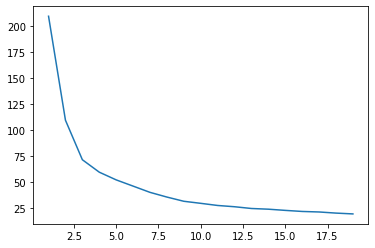

In [97]:
test_kmeans(20,insightsIhfa_Dump)

In [83]:
k_means_labels, k_means_cluster_centers = run_kmeans(5, insightsIhfa_Dump)

Centroids:
[[-0.03115253 -0.68010393 -0.09704139 -0.28812077  0.07936551]
 [ 0.04172778  0.63867494 -0.03588784 -0.3546839   0.0985064 ]
 [-0.7254457   0.64084684  0.0176389  -0.29192732  0.09284521]
 [ 0.47930459 -0.77933124 -0.0543051   0.58510361  0.10879469]
 [ 0.56609586 -0.77598108  0.00876602 -0.59909958  0.12317688]]


In [84]:
transposed = pd.DataFrame(data=k_means_labels)
parsed = insightsIhfa_Dump.dropna().reset_index().join(transposed)
parsed = parsed.set_index("CNPJ")
parsed = parsed.rename(columns={0:"resultKmeans"})

In [85]:
lista_interpretada = firstFundFilterLayer[["CNPJ_FUNDO","DENOM_SOCIAL"]].set_index("CNPJ_FUNDO")
lista_interpretada=lista_interpretada.reset_index().rename(columns={"CNPJ_FUNDO":"CNPJ"}).set_index("CNPJ")
print(parsed.shape)
parsed = parsed.join(lista_interpretada)
print(parsed.shape)

(237, 6)
(237, 7)


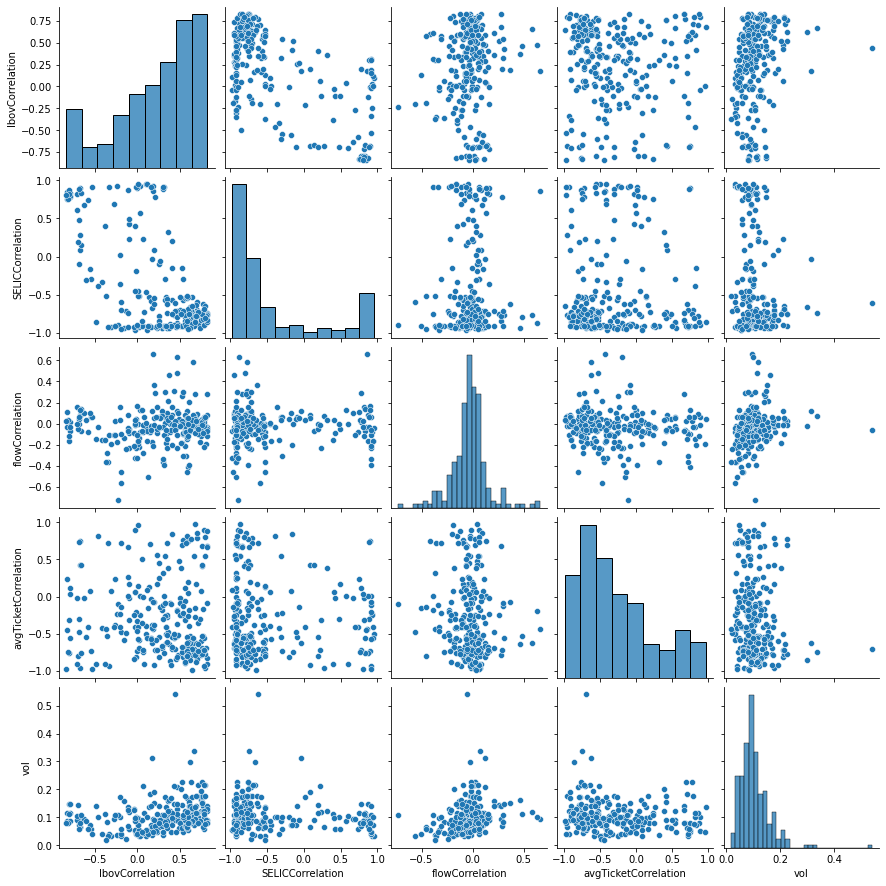

In [99]:
sns.pairplot(insightsIhfa_Dump)

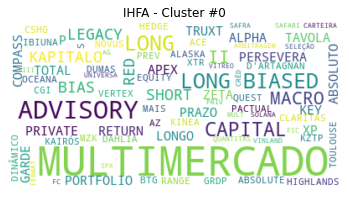

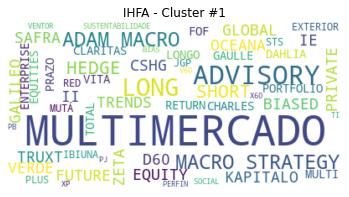

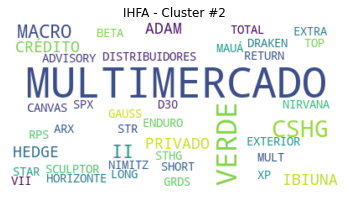

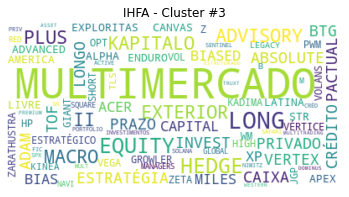

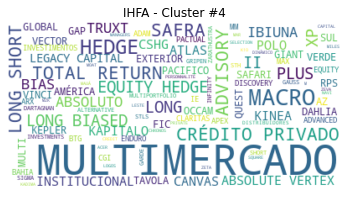

In [86]:
plot_wordcloud(parsed, 5, "IHFA")

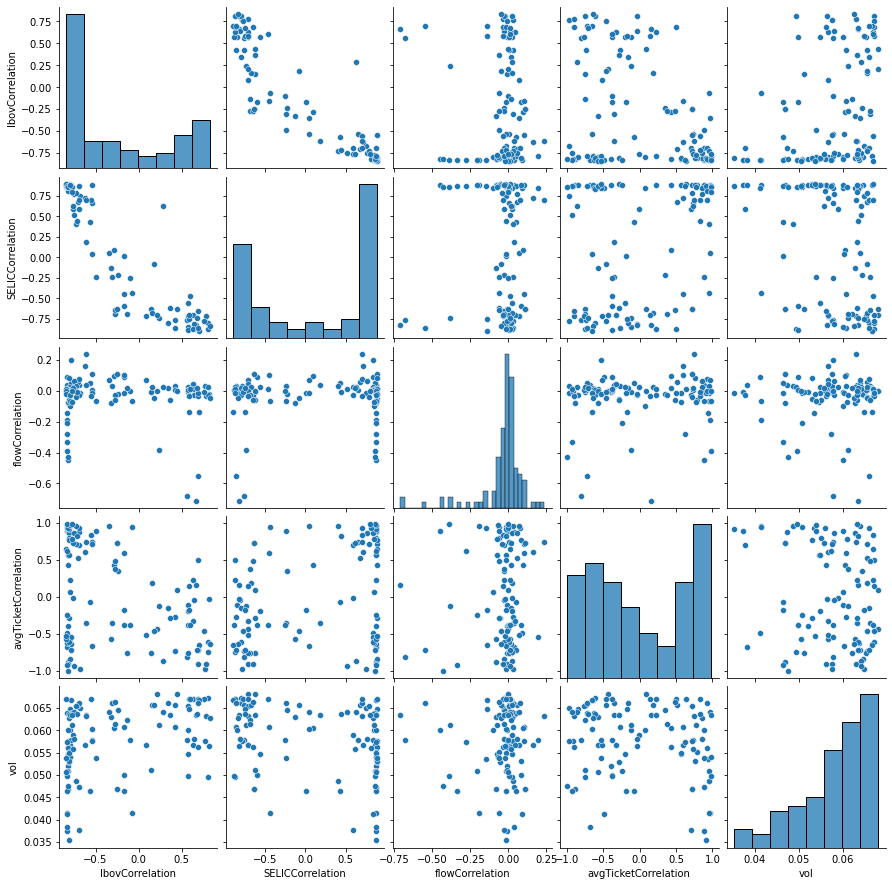

In [100]:
sns.pairplot(insightsFI_Dump)

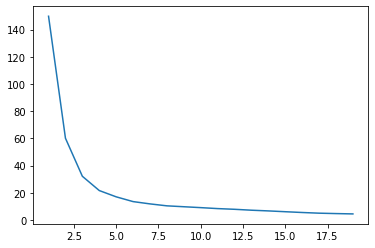

In [87]:
test_kmeans(20,insightsFI_Dump)

In [88]:
k_means_labels, k_means_cluster_centers = run_kmeans(5, insightsFI_Dump)

Centroids:
[[-0.7540533   0.78961654 -0.0295391   0.77517369  0.05579325]
 [ 0.57221473 -0.75780731 -0.0802211  -0.38469902  0.06167884]
 [-0.79278684  0.81611546 -0.03432004 -0.58025315  0.0551928 ]
 [-0.18929198 -0.11293454  0.00368571 -0.49618601  0.05987475]
 [-0.226657   -0.40614011  0.0249364   0.60565941  0.0574748 ]]


In [89]:
transposed = pd.DataFrame(data=k_means_labels)
parsed = insightsFI_Dump.dropna().reset_index().join(transposed)
parsed = parsed.set_index("CNPJ")
parsed = parsed.rename(columns={0:"resultKmeans"})

parsed = parsed.join(lista_interpretada)
print(parsed.shape)
parsed.head()

(111, 7)


,IbovCorrelation,SELICCorrelation,flowCorrelation,avgTicketCorrelation,vol,resultKmeans,DENOM_SOCIAL
CNPJ,,,,,,,
00.756.851/0001-69,-0.249271,-0.632219,0.109614,0.723898,0.046894,4,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE IN...
00.822.933/0001-64,-0.676936,0.750529,-0.015103,-0.967451,0.064953,2,ITAÚ B RENDA FIXA REFERENCIADO DI FUNDO DE INV...
00.824.198/0001-28,-0.797923,0.866031,0.013381,-0.567140,0.056637,2,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUN...
00.826.386/0001-95,-0.695067,0.871036,0.036291,0.877895,0.047240,0,ITAÚ BASIS OPEN RENDA FIXA REFERENCIADO DI FUN...
00.826.907/0001-04,-0.815289,0.883715,0.018441,0.430718,0.056193,0,ITAÚ MEDIUM TERM CAPITAL FIX RENDA FIXA REFERE...


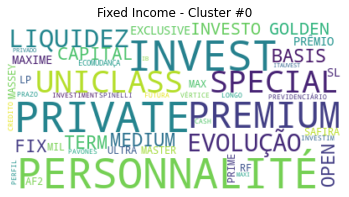

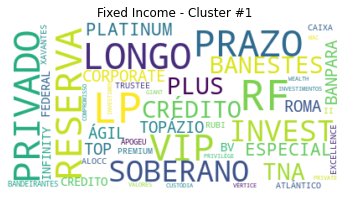

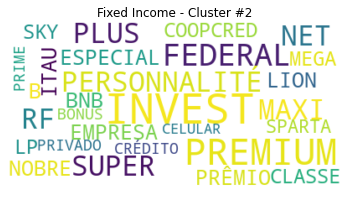

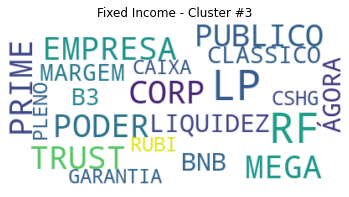

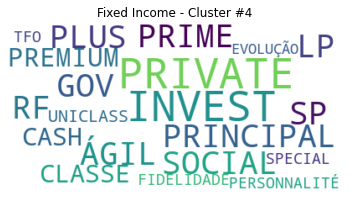

In [90]:
plot_wordcloud(parsed, 5, "Fixed Income")

In [91]:
transposed = pd.DataFrame(data=k_means_labels)
parsed = insightsFI_Dump.dropna().reset_index().join(transposed)
parsed = parsed.set_index("CNPJ")
parsed = parsed.rename(columns={0:"resultKmeans"})

parsed = parsed.join(lista_interpretada)
print(parsed.shape)


(111, 7)


In [93]:
#plot_wordcloud(parsed, 5, "FI")

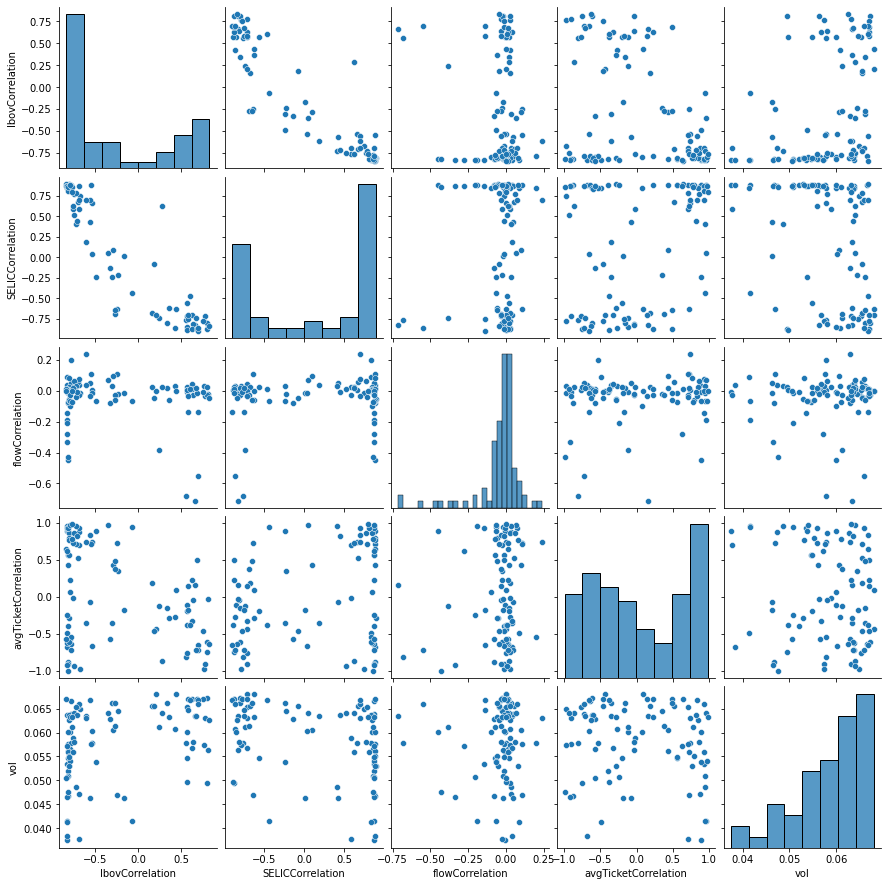

In [101]:
sns.pairplot(insightsInterbankRate_Dump)